In [1]:
import pandas as pd
import re
import numpy as np
from ast import literal_eval

In [2]:
import sys
sys.path.append('../utils/')
from flatten import flatten

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
%matplotlib inline
from statannot import add_stat_annotation
import plotly.express as px

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

### Difference in non minus immunogenic (IEDB)

In [4]:
iedb_df = pd.read_csv('../data/IEDB/aggregated.hyperboloid_disk.10-01.tsv', sep='\t')
iedb_df['cc_ids'] = iedb_df['cc_ids'].apply(literal_eval)

print(iedb_df.shape)
iedb_df.head(2)

(2949, 32)


,index,Reference PubMed ID,Assay Antigen Antigen Description,Epitope Description,Assay Method/Technique,Assay Assay Group,Assay Qualitative Measure,Antigen Presenting Cells Cell Tissue Type,MHC Allele Name,Related Object Parent Protein IRI,...,foreignness_score,Peptide,nM,Rank,Thalf(h),Entry,UMAP1,UMAP2,cc_ids,immunogenic
0,A0A087WUL8,27198675,SSFHALEEK,SSFHALEEK,biological activity,activation,Negative,Blood,HLA-A*11:01,http://www.uniprot.org/uniprot/A0A087WUL8,...,0.000059,SSFHALEEK,10.3012,0.0271,6.7664,A0A087WUL8,0.959718,-0.048351,[GO:0005737],0
1,A0A087WUL8,27198675,GSSFHALEEK,GSSFHALEEK,biological activity,activation,Negative,Blood,HLA-A*11:01,http://www.uniprot.org/uniprot/A0A087WUL8,...,0.000059,GSSFHALEEK,34.7047,0.2095,3.8003,A0A087WUL8,0.959718,-0.048351,[GO:0005737],0


In [5]:
# for plotting, keep only 1 immunogenic or non immunogenic peptide per protein, per study
iedb_df = iedb_df.drop_duplicates(subset=['Entry','immunogenic','Reference PubMed ID'])
print(iedb_df.shape)

(1548, 32)


In [6]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=25, mincnt=1, cmap=cmap, **kwargs)
    plt.colorbar()

### non-immuno vs immunogenic locations

(1503, 32)


/cellar/users/andreabc/miniconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:316: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



Saving to ../data/publication_figures/Fig2AB.IEDB.location_vs_immunogenic.facet_hex.pdf


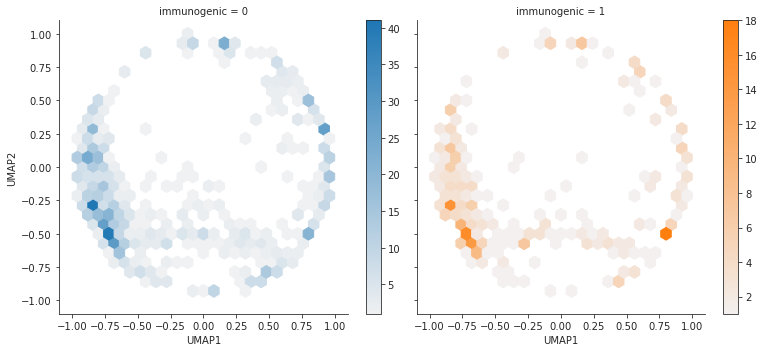

In [7]:
plot_df = iedb_df.drop_duplicates(subset=['Epitope Description', 'immunogenic',
                                          'Gene ontology (cellular component)'])
print(plot_df.shape)
g = sns.FacetGrid(plot_df, hue="immunogenic", col="immunogenic", size=5, height=4, aspect=1.1)
g.map(hexbin, "UMAP1", "UMAP2", extent=[-1, 1, -1, 1],)

savepath = '../data/publication_figures/Fig2AB.IEDB.location_vs_immunogenic.facet_hex.pdf'
print('Saving to {}'.format(savepath))
plt.savefig(savepath, bbox_inches='tight')
plt.show()

printing 6
-0.8841570817701127 -0.2574738964285713
mitochondrial matrix [GO:0005759]
-0.7302342414622669 -0.3927830571428571
apical plasma membrane [GO:0016324]; cell [GO:0005623]; endoplasmic reticulum membrane [GO:0005789]; focal adhesion [GO:0005925]; integral component of membrane [GO:0016021]; mitochondrion [GO:0005739]; NADPH oxidase complex [GO:0043020]; nucleolus [GO:0005730]; nucleoplasm [GO:0005654]; nucleus [GO:0005634]; perinuclear endoplasmic reticulum [GO:0097038]; perinuclear region of cytoplasm [GO:0048471]; plasma membrane [GO:0005886]; stress fiber [GO:0001725]
-0.6532728213083441 -0.5280922178571428
costamere [GO:0043034]; cytoplasmic side of plasma membrane [GO:0009898]; cytosol [GO:0005829]; dystrophin-associated glycoprotein complex [GO:0016010]; focal adhesion [GO:0005925]; intercalated disc [GO:0014704]; sarcolemma [GO:0042383]; spot adherens junction [GO:0005914]; stress fiber [GO:0001725]; Z disc [GO:0030018]
-0.9226377918470741 0.0807990053571429
mitochondria

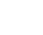

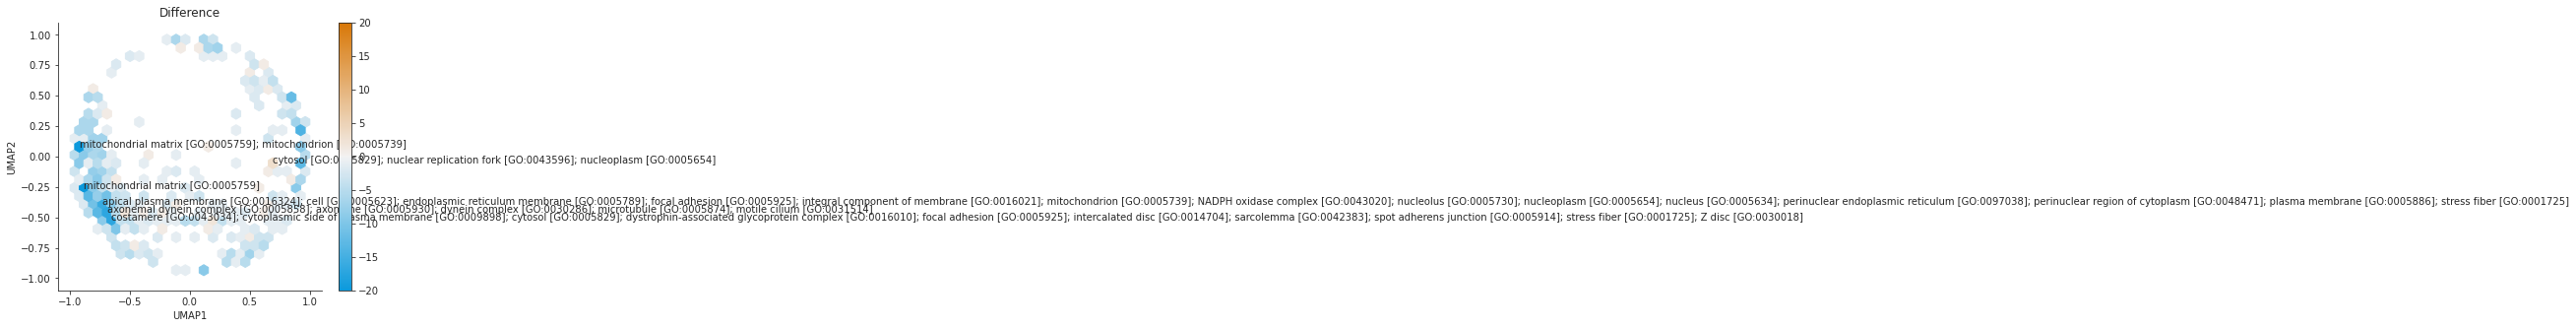

In [8]:
# difference
gridsize=25
printed_labels = []

fig = plt.figure(figsize=(0.01,0.01))

h1=plt.hexbin(plot_df[plot_df['immunogenic']==0]['UMAP1'], plot_df[plot_df['immunogenic']==0]['UMAP2'],
              gridsize=gridsize, cmap=plt.cm.Blues)
h2=plt.hexbin(plot_df[plot_df['immunogenic']==1]['UMAP1'], plot_df[plot_df['immunogenic']==1]['UMAP2'],
              gridsize=gridsize,cmap=plt.cm.Reds)
fig.set_visible(False)


plt.figure(figsize=(6,5))
# # Create dummy hexbin using whatever data..:
h3 = plt.hexbin(plot_df['UMAP1'], plot_df['UMAP2'], gridsize=gridsize, vmin=-20, vmax=20,
              cmap=sns.diverging_palette(240, 35, s=99, sep=1, l=60, as_cmap=True))
diff_array = h2.get_array()-h1.get_array()
diff_array[diff_array==0] = np.nan # hide zeros
h3.set_array(diff_array)
plt.colorbar()

# labels
plt.xlabel('UMAP1'), plt.ylabel('UMAP2')
plt.xlim(-1.1,1.1), plt.ylim(-1.1,1.1)
h3.axes.spines['right'].set_visible(False)
h3.axes.spines['top'].set_visible(False)
plt.title('Difference')

# annotate top hits
hex_counts = h3.get_array()
immuno_thresh = 3
nonimmuno_thresh = -15

indices = [i for i,x in enumerate(hex_counts) if x>=immuno_thresh or x<=nonimmuno_thresh]
top = np.array([h3.get_offsets()[x] for x in indices])
buffer = 0.05

# plot top CCs
print('printing {}'.format(len(top)))
for t in top:
    x,y=t
    
    df = plot_df[(plot_df['UMAP1']>=x-buffer)&(plot_df['UMAP1']<=x+buffer) &
                 (plot_df['UMAP2']>=y-buffer)&(plot_df['UMAP2']<=y+buffer)]
    print(x,y)
    top_ccs = df['Gene ontology (cellular component)'].value_counts()
    if len(top_ccs)>0:
        top_ccs = top_ccs.index[0] 
        print(top_ccs)

        printed_labels.extend(top_ccs)
    
        plt.text(x,y,top_ccs)



# plt.tight_layout()

savepath = '../data/publication_figures/Fig2C.IEDB.location_vs_immunogenic.difference.top_CC.facet_hex_w_loc.pdf'
print('saving to {}'.format(savepath))
plt.savefig(savepath, bbox_inches='tight')
plt.show()